# CODE FOR NON-STATIONARY SPECTRAL MIXTURE KENREL GP

# Load and process data

In [1]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/train_set.csv', index_col = 0)
test_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/test_set.csv', index_col = 0)
data = pd.concat([train_data,test_data], axis = 0)

In [5]:
train_data = pd.read_csv(r'/content/drive/MyDrive/STAT0035/train_set.csv', index_col = 0)
# Get the list of all columns
all_columns = data.columns.tolist()

# Columns to exclude from scaling
exclude_columns = ['Date.time', 'turbine', 'year']

# Columns to be standardized (input features + output)
columns_to_standardize = [col for col in all_columns if col not in exclude_columns]

# Dictionary to store mean and standard deviation for each column
standardization_parameters = {}

# Standardization
for col in columns_to_standardize:
    mean = data[col].mean()
    std = data[col].std()
    standardization_parameters[col] = {'mean': mean, 'std': std}
    data[col] = (data[col] - mean) / std

In [6]:
turbine_1 = data[data['turbine'] == 1].reset_index()
turbine_2 = data[data['turbine'] == 2].reset_index()
turbine_3 = data[data['turbine'] == 3].reset_index()
turbine_4 = data[data['turbine'] == 4].reset_index()
turbine_5 = data[data['turbine'] == 5].reset_index()
turbine_6 = data[data['turbine'] == 6].reset_index()

In [7]:
# # Step 1: Identify common 'Date.time' values
# common_dates = set(turbine_1['Date.time'])

# # Using intersection to find common 'Date.time' values across all turbines
# common_dates = common_dates.intersection(turbine_2['Date.time'])
# common_dates = common_dates.intersection(turbine_3['Date.time'])
# common_dates = common_dates.intersection(turbine_4['Date.time'])
# common_dates = common_dates.intersection(turbine_5['Date.time'])
# common_dates = common_dates.intersection(turbine_6['Date.time'])

# # Step 2: Filter each DataFrame to keep only rows with 'Date.time' in common_dates
# turbine_1_filtered = turbine_1[turbine_1['Date.time'].isin(common_dates)][0:90000]
# turbine_2_filtered = turbine_2[turbine_2['Date.time'].isin(common_dates)][0:90000]
# turbine_3_filtered = turbine_3[turbine_3['Date.time'].isin(common_dates)][0:90000]
# turbine_4_filtered = turbine_4[turbine_4['Date.time'].isin(common_dates)][0:90000]
# turbine_5_filtered = turbine_5[turbine_5['Date.time'].isin(common_dates)][0:90000]
# turbine_6_filtered = turbine_6[turbine_6['Date.time'].isin(common_dates)][0:90000]

In [8]:
a = 1000


train_turbine_1, test_turbine_1 = turbine_1.iloc[:3000].reset_index(drop=True), turbine_1.iloc[3000:4000].reset_index(drop=True)
train_turbine_2, test_turbine_2 = turbine_2.iloc[:3000].reset_index(drop=True), turbine_2.iloc[3000:4000].reset_index(drop=True)
train_turbine_3, test_turbine_3 = turbine_3.iloc[:3000].reset_index(drop=True), turbine_3.iloc[3000:4000].reset_index(drop=True)
train_turbine_4, test_turbine_4 = turbine_4.iloc[:3000].reset_index(drop=True), turbine_4.iloc[3000:4000].reset_index(drop=True)
train_turbine_5, test_turbine_5 = turbine_5.iloc[:3000].reset_index(drop=True), turbine_5.iloc[3000:4000].reset_index(drop=True)
train_turbine_6, test_turbine_6 = turbine_6.iloc[:3000].reset_index(drop=True), turbine_6.iloc[3000:4000].reset_index(drop=True)

In [9]:
features =[
 'Wind.speed.me',
#  'Power.factor.cosphi.me',
#  'Front.bearing.temp.me',
#  'Stator1.temp.me',
#  'Nacelle.ambient.temp.me',
 'Nacelle.temp.me',
#  'Transformer.temp.me',
#  'Gear.oil.temp.me',
#  'Generator.bearing.rear.temp.me',
#  'Generator.bearing.front.temp.me',
#  'Motor.axis1.temp.me',
#  'CPU.temp.me',
#  'Rotor.speed.me',
#  'Gear.oil.inlet.press.me',
#  'Drive.train.acceleration.me',
 'Tower.Acceleration.x',
#  'Tower.Acceleration.y',
 ]

In [10]:
X_train = pd.concat([train_turbine_1[features], train_turbine_2[features],
                   train_turbine_3[features], train_turbine_4[features],
                   train_turbine_5[features], train_turbine_6[features]])

Y_train = pd.concat([train_turbine_1['Power.me'], train_turbine_2['Power.me'],
                   train_turbine_3['Power.me'], train_turbine_4['Power.me'],
                   train_turbine_5['Power.me'], train_turbine_6['Power.me']])


train_i_task1 = torch.full((train_turbine_1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_turbine_2.shape[0],1), dtype=torch.long, fill_value=1)
train_i_task3 = torch.full((train_turbine_3.shape[0],1), dtype=torch.long, fill_value=2)
train_i_task4 = torch.full((train_turbine_4.shape[0],1), dtype=torch.long, fill_value=3)
train_i_task5 = torch.full((train_turbine_5.shape[0],1), dtype=torch.long, fill_value=4)
train_i_task6 = torch.full((train_turbine_6.shape[0],1), dtype=torch.long, fill_value=5)

full_train_i = torch.cat([train_i_task1, train_i_task2, train_i_task3,
                          train_i_task4, train_i_task5, train_i_task6])

full_train_x = torch.tensor(X_train.values.astype(float)).float()
full_train_y = torch.tensor(Y_train.values.astype(float)).float()

In [11]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(),ard_num_dims=3)

        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=6, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)

        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)

        # print('x:', x.shape)
        # print('i:', x.shape)
        # print('covar_x:', covar_x.shape)
        # print('covar_i:', covar_i.shape)
        # print('covar:', covar.shape)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

In [12]:
# Function to initialise model and likelihood objects
def create_model_and_likelihood(full_train_x, full_train_y, full_train_i):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)
    return model, likelihood

# Function to save the model and likelihood with an initialization identifier
def save_checkpoint(model, likelihood, iteration, init, folder='/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (1 to 10 - Attempt 4)'):
    os.makedirs(folder, exist_ok=True)
    torch.save(model.state_dict(), f'{folder}/model_state_init{init}_iter{iteration}.pth')
    torch.save(likelihood.state_dict(), f'{folder}/likelihood_state_init{init}_iter{iteration}.pth')

In [13]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 5000
n_initializations = 5  # Number of initializations
best_loss = float('inf')
best_model = None
best_likelihood = None

# Training loop for multiple initializations
for init in range(1,2):

    model, likelihood = create_model_and_likelihood(full_train_x, full_train_y, full_train_i)

    model.train()
    likelihood.train()

    model = model.float()
    likelihood = likelihood.float()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with tqdm(total=training_iter, desc=f"Training Progress (Init {init})") as pbar:
        for i in range(training_iter):
          optimizer.zero_grad()
          output = model(full_train_x, full_train_i)
          loss = -mll(output, full_train_y)
          loss.backward()
          optimizer.step()

          pbar.set_postfix(loss=loss.item())
          pbar.update(1)

          if (i + 1) % 100 == 0:
              save_checkpoint(model, likelihood, i + 1, init)  # Save checkpoint every 50 iterations for each init

    # Compare and store the best model
    final_loss = loss.item()
    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_likelihood = likelihood

# Save the best model and likelihood
save_checkpoint(best_model, best_likelihood, 'final', 'best')

print(f'Best Loss: {best_loss}')

Training Progress (Init 1):   0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
Training Progress (Init 1): 100%|██████████| 5000/5000 [15:25:10<00:00, 11.10s/it, loss=-0.351]

Best Loss: -0.35068824887275696


In [14]:
model, likelihood = create_model_and_likelihood(full_train_x, full_train_y, full_train_i)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [15]:
# Load saved model and likelihood
model.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (2k)/model_state_init1_iter200.pth'))
likelihood.load_state_dict(torch.load('/content/drive/MyDrive/STAT0035/Thesis Writing/Chapter 6.3 - RBF vs MTGP/MTGP (2k)/likelihood_state_init1_iter200.pth'))

<All keys matched successfully>

In [16]:
# Calculate loss if necessary. Note that this cell shouldn't be run twice because it will explode
# -mll(model(train_x), train_y)

### Making Prediction

Changing hyperparameters back to float64 is important for gpytorch.settings.fast_pred_var()

In [17]:
# X_test = pd.concat([test_turbine_1['encoded_input'], test_turbine_2['encoded_input'],
#                    test_turbine_3['encoded_input'], test_turbine_4['encoded_input'],
#                    test_turbine_5['encoded_input'], test_turbine_6['encoded_input']])

# Y_test = pd.concat([test_turbine_1['Power.me'], test_turbine_2['Power.me'],
#                    test_turbine_3['Power.me'], test_turbine_4['Power.me'],
#                    test_turbine_5['Power.me'], test_turbine_6['Power.me']])


test_i_task1 = torch.full((test_turbine_1.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_turbine_2.shape[0],1), dtype=torch.long, fill_value=1)
test_i_task3 = torch.full((test_turbine_3.shape[0],1), dtype=torch.long, fill_value=2)
test_i_task4 = torch.full((test_turbine_4.shape[0],1), dtype=torch.long, fill_value=3)
test_i_task5 = torch.full((test_turbine_5.shape[0],1), dtype=torch.long, fill_value=4)
test_i_task6 = torch.full((test_turbine_6.shape[0],1), dtype=torch.long, fill_value=5)

test_x_turbine_1 = torch.tensor(test_turbine_1[features].values.astype(float)).float()
test_x_turbine_2 = torch.tensor(test_turbine_2[features].values.astype(float)).float()
test_x_turbine_3 = torch.tensor(test_turbine_3[features].values.astype(float)).float()
test_x_turbine_4 = torch.tensor(test_turbine_4[features].values.astype(float)).float()
test_x_turbine_5 = torch.tensor(test_turbine_5[features].values.astype(float)).float()
test_x_turbine_6 = torch.tensor(test_turbine_6[features].values.astype(float)).float()


In [18]:
model = model.to(torch.float64)
likelihood = likelihood.to(torch.float64)

In [19]:
# Your existing training code here

# Make predictions on training data for confidence interval
model.eval()
likelihood.eval()

# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     train_observed_pred = likelihood(model.predict(train_x))
#     train_lower, train_upper = train_observed_pred.confidence_region()
#     train_mean = train_observed_pred.mean.detach().numpy()
#     train_variance = train_observed_pred.variance.detach().numpy()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x_turbine_1, test_i_task1))
    observed_pred_y2 = likelihood(model(test_x_turbine_2, test_i_task2))
    observed_pred_y3 = likelihood(model(test_x_turbine_3, test_i_task3))
    observed_pred_y4 = likelihood(model(test_x_turbine_4, test_i_task4))
    observed_pred_y5 = likelihood(model(test_x_turbine_5, test_i_task5))
    observed_pred_y6 = likelihood(model(test_x_turbine_6, test_i_task6))

In [20]:
mean_pred_y1 = observed_pred_y1.mean.detach().numpy()
mean_pred_y2 = observed_pred_y2.mean.detach().numpy()
mean_pred_y3 = observed_pred_y3.mean.detach().numpy()
mean_pred_y4 = observed_pred_y4.mean.detach().numpy()
mean_pred_y5 = observed_pred_y5.mean.detach().numpy()
mean_pred_y6 = observed_pred_y6.mean.detach().numpy()

var_pred_y1 = observed_pred_y1.variance.detach().numpy()
var_pred_y2 = observed_pred_y2.variance.detach().numpy()
var_pred_y3 = observed_pred_y3.variance.detach().numpy()
var_pred_y4 = observed_pred_y4.variance.detach().numpy()
var_pred_y5 = observed_pred_y5.variance.detach().numpy()
var_pred_y6 = observed_pred_y6.variance.detach().numpy()

test_lower_y1, test_upper_y1 = observed_pred_y1.confidence_region()
test_lower_y2, test_upper_y2 = observed_pred_y2.confidence_region()
test_lower_y3, test_upper_y3 = observed_pred_y3.confidence_region()
test_lower_y4, test_upper_y4 = observed_pred_y4.confidence_region()
test_lower_y5, test_upper_y5 = observed_pred_y5.confidence_region()
test_lower_y6, test_upper_y6 = observed_pred_y6.confidence_region()

### Rescale Power.me to before standardisation

In [21]:
def rescale_to_original(value, col, dictionary):
    params = dictionary[col]
    return value * params['std'] + params['mean']


mean_pred_y1_og = rescale_to_original(mean_pred_y1, 'Power.me', standardization_parameters)
mean_pred_y2_og = rescale_to_original(mean_pred_y2, 'Power.me', standardization_parameters)
mean_pred_y3_og = rescale_to_original(mean_pred_y3, 'Power.me', standardization_parameters)
mean_pred_y4_og = rescale_to_original(mean_pred_y4, 'Power.me', standardization_parameters)
mean_pred_y5_og = rescale_to_original(mean_pred_y5, 'Power.me', standardization_parameters)
mean_pred_y6_og = rescale_to_original(mean_pred_y6, 'Power.me', standardization_parameters)


var_pred_y1_og = rescale_to_original(var_pred_y1, 'Power.me', standardization_parameters)
var_pred_y2_og = rescale_to_original(var_pred_y2, 'Power.me', standardization_parameters)
var_pred_y3_og = rescale_to_original(var_pred_y3, 'Power.me', standardization_parameters)
var_pred_y4_og = rescale_to_original(var_pred_y4, 'Power.me', standardization_parameters)
var_pred_y5_og = rescale_to_original(var_pred_y5, 'Power.me', standardization_parameters)
var_pred_y6_og = rescale_to_original(var_pred_y6, 'Power.me', standardization_parameters)

test_lower_y1_og = rescale_to_original(test_lower_y1, 'Power.me', standardization_parameters)
test_lower_y2_og = rescale_to_original(test_lower_y2, 'Power.me', standardization_parameters)
test_lower_y3_og = rescale_to_original(test_lower_y3, 'Power.me', standardization_parameters)
test_lower_y4_og = rescale_to_original(test_lower_y4, 'Power.me', standardization_parameters)
test_lower_y5_og = rescale_to_original(test_lower_y5, 'Power.me', standardization_parameters)
test_lower_y6_og = rescale_to_original(test_lower_y6, 'Power.me', standardization_parameters)

test_upper_y1_og = rescale_to_original(test_upper_y1, 'Power.me', standardization_parameters)
test_upper_y2_og = rescale_to_original(test_upper_y2, 'Power.me', standardization_parameters)
test_upper_y3_og = rescale_to_original(test_upper_y3, 'Power.me', standardization_parameters)
test_upper_y4_og = rescale_to_original(test_upper_y4, 'Power.me', standardization_parameters)
test_upper_y5_og = rescale_to_original(test_upper_y5, 'Power.me', standardization_parameters)
test_upper_y6_og = rescale_to_original(test_upper_y6, 'Power.me', standardization_parameters)


obs_y1_og = rescale_to_original(test_turbine_1['Power.me'], 'Power.me', standardization_parameters)
obs_y2_og = rescale_to_original(test_turbine_2['Power.me'], 'Power.me', standardization_parameters)
obs_y3_og = rescale_to_original(test_turbine_3['Power.me'], 'Power.me', standardization_parameters)
obs_y4_og = rescale_to_original(test_turbine_4['Power.me'], 'Power.me', standardization_parameters)
obs_y5_og = rescale_to_original(test_turbine_5['Power.me'], 'Power.me', standardization_parameters)
obs_y6_og = rescale_to_original(test_turbine_6['Power.me'], 'Power.me', standardization_parameters)

### Observing the range and distribution of re-scaled values. Good to check variance and bounds because sometimes they are too large or too small

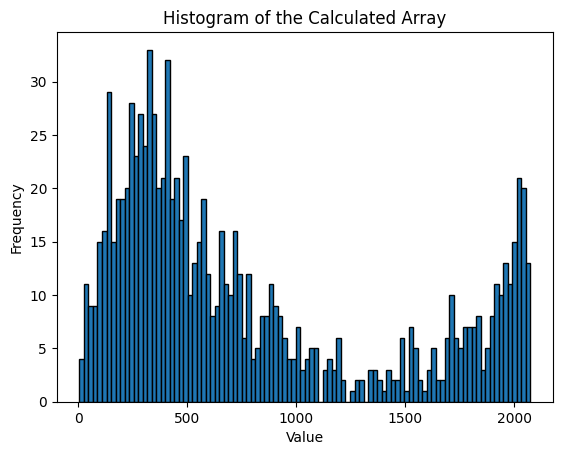

In [22]:
plt.hist(mean_pred_y1_og, bins=100, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of the Calculated Array')
plt.show()

### Calculate Coverage Probability

In [23]:
# def calculate_coverage_probability(y_true, lower_bound, upper_bound):

#     # Count how many true values fall within the prediction intervals
#     covered = ((y_true >= lower_bound) & (y_true <= upper_bound)).sum()

#     # Calculate the coverage probability
#     coverage_probability = covered / len(y_true)

#     return coverage_probability

# # Calculate coverage probability for training data
# # train_coverage_probability = calculate_coverage_probability(train_y_original, train_lower_original, train_upper_original)

# # Calculate coverage probability for test data
# test_coverage_probability = calculate_coverage_probability(test_y_original, test_lower_original, test_upper_original)

# # Output the results
# # print(f"Training Data Coverage Probability: {train_coverage_probability}")
# print(f"Test Data Coverage Probability: {test_coverage_probability}")

### Calculate RMSE and Standard Error of model on training and testing data

In [24]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Function to calculate Standard Error
def standard_error(y_true, y_pred):
    std_dev = np.std(y_true - y_pred)
    return std_dev / np.sqrt(len(y_true))

def calculate_nlpd(predicted_mean, predicted_var, actual_y):

    # Calculate the Gaussian PDF value for each test point
    pdf_values = 1 / np.sqrt(2 * np.pi * predicted_var) * np.exp(-0.5 * (actual_y - predicted_mean)**2 / predicted_var)

    pdf_values = pdf_values[pdf_values>0]
    # Calculate the Negative Log-Predictive Density (NLPD)
    nlpd = -np.mean(np.log(pdf_values))

    return nlpd


# Calculate RMSE and NLPD for test data
test_rmse_y1 = rmse(obs_y1_og, mean_pred_y1_og)
test_rmse_y2 = rmse(obs_y2_og, mean_pred_y2_og)
test_rmse_y3 = rmse(obs_y3_og, mean_pred_y3_og)
test_rmse_y4 = rmse(obs_y4_og, mean_pred_y4_og)
test_rmse_y5 = rmse(obs_y5_og, mean_pred_y5_og)
test_rmse_y6 = rmse(obs_y6_og, mean_pred_y6_og)



test_nlpd_y1 = calculate_nlpd(mean_pred_y1_og, var_pred_y1_og , obs_y1_og)
test_nlpd_y2 = calculate_nlpd(mean_pred_y2_og, var_pred_y2_og , obs_y2_og)
test_nlpd_y3 = calculate_nlpd(mean_pred_y3_og, var_pred_y3_og , obs_y3_og)
test_nlpd_y4 = calculate_nlpd(mean_pred_y4_og, var_pred_y4_og , obs_y4_og)
test_nlpd_y5 = calculate_nlpd(mean_pred_y5_og, var_pred_y5_og , obs_y5_og)
test_nlpd_y6 = calculate_nlpd(mean_pred_y6_og, var_pred_y6_og , obs_y6_og)

In [25]:
print("-------RMSE--------")
print("Turbine 1 RMSE:", test_rmse_y1)
print("Turbine 2 RMSE:", test_rmse_y2)
print("Turbine 3 RMSE:", test_rmse_y3)
print("Turbine 4 RMSE:", test_rmse_y4)
print("Turbine 5 RMSE:", test_rmse_y5)
print("Turbine 6 RMSE:", test_rmse_y6)
print("-------NLPD--------")
print("Turbine 1 NLPD:", test_nlpd_y1)
print("Turbine 2 NLPD:", test_nlpd_y2)
print("Turbine 3 NLPD:", test_nlpd_y3)
print("Turbine 4 NLPD:", test_nlpd_y4)
print("Turbine 5 NLPD:", test_nlpd_y5)
print("Turbine 6 NLPD:", test_nlpd_y6)

-------RMSE--------
Turbine 1 RMSE: 65.41797434966838
Turbine 2 RMSE: 68.18832646525635
Turbine 3 RMSE: 63.44901078916172
Turbine 4 RMSE: 67.20954242092337
Turbine 5 RMSE: 61.78418032875374
Turbine 6 RMSE: 61.49844222310846
-------NLPD--------
Turbine 1 NLPD: 6.306577324676757
Turbine 2 NLPD: 6.530619898439661
Turbine 3 NLPD: 6.214149423359806
Turbine 4 NLPD: 6.269920536906516
Turbine 5 NLPD: 6.120905642487902
Turbine 6 NLPD: 6.038474191666547


### Making Plots

In [26]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Given variables: mean_pred_y*_og, obs_y*_og, test_lower_y*_og, test_upper_y*_og for turbines 1 to 6
# Example for turbine 1, you can replicate this for others

# Adjusting the function to plot for a selected turbine
def update_plot(turbine_id, x_range):
    # Map the turbine_id to the respective variables
    mean_pred_og = [mean_pred_y1_og, mean_pred_y2_og, mean_pred_y3_og, mean_pred_y4_og, mean_pred_y5_og, mean_pred_y6_og][turbine_id-1]
    obs_og = [obs_y1_og, obs_y2_og, obs_y3_og, obs_y4_og, obs_y5_og, obs_y6_og][turbine_id-1]
    test_lower_og = [test_lower_y1_og, test_lower_y2_og, test_lower_y3_og, test_lower_y4_og, test_lower_y5_og, test_lower_y6_og][turbine_id-1]
    test_upper_og = [test_upper_y1_og, test_upper_y2_og, test_upper_y3_og, test_upper_y4_og, test_upper_y5_og, test_upper_y6_og][turbine_id-1]

    # Plot settings
    f, ax = plt.subplots(1, 1, figsize=(20, 10))
    start, end = x_range
    ax.set_xlim(start, end)

    # Plot observed data points
    ax.scatter(range(len(obs_og)), obs_og, color='black', s=1, label="Observed Data")

    # Plot mean prediction line
    ax.plot(range(len(mean_pred_og)), mean_pred_og, 'r--', label="Predictive Mean")

    # Plot confidence interval
    ax.fill_between(range(len(test_lower_og)), test_lower_og, test_upper_og, alpha=0.2, color='red', label="Confidence Interval")

    # Labels and title
    ax.set_xlabel("Time (10-min Intervals)")
    ax.set_ylabel("Power")
    ax.set_title(f"GP Prediction for Turbine {turbine_id}")
    ax.legend()

    plt.show()

# Widget to select turbine
turbine_selector = widgets.Dropdown(
    options=[('Turbine 1', 1), ('Turbine 2', 2), ('Turbine 3', 3), ('Turbine 4', 4), ('Turbine 5', 5), ('Turbine 6', 6)],
    value=1,
    description='Turbine:',
)

# Slider for x-axis range
x_max = max(len(obs_y1_og), len(obs_y2_og), len(obs_y3_og), len(obs_y4_og), len(obs_y5_og), len(obs_y6_og))
x_slider = widgets.IntRangeSlider(
    value=[0, x_max],
    min=0,
    max=x_max,
    step=1,
    description='X-axis Range:',
    continuous_update=False
)

# Combine widgets for interaction
interact(update_plot, turbine_id=turbine_selector, x_range=x_slider)

interactive(children=(Dropdown(description='Turbine:', options=(('Turbine 1', 1), ('Turbine 2', 2), ('Turbine …

<function __main__.update_plot(turbine_id, x_range)>

### Plot of predicted vs observed values of Power

In [27]:
# Find the minimum and maximum values for the x and y axes
min_val = min(train_y_original.min(), test_y_original.min(), 0, test_mean_original.min())
max_val = max(train_y_original.max(), test_y_original.max(), 2000, test_mean_original.max())

# Create a subplot with enhanced aesthetics
f2, ax2 = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for training data
# ax2.scatter(train_y_original, train_mean_original, color='blue', alpha=0.5, s=1, label='Training Data', zorder=5)

# Scatter plot for testing data
ax2.scatter(test_y_original, test_mean_original, color='red', alpha=0.5, s=1, label='Testing Data', zorder=5)

# 45-degree line through the origin
ax2.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='45-degree line')

# Set the limits for x and y axes
ax2.set_xlim([min_val, max_val])
ax2.set_ylim([min_val, max_val])

# Aesthetic improvements
ax2.set_xlabel('Observed Power', fontsize=14)
ax2.set_ylabel('Predicted Power', fontsize=14)
ax2.set_title('Predicted vs Observed Power for Testing Data', fontsize=16)
ax2.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax2.legend(loc='upper left')

plt.show()


NameError: name 'train_y_original' is not defined

### Residual Diagnostics

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# residuals_train = train_y_original - train_mean_original

# # Plotting residuals for training data
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=train_mean_original, y=residuals_train, size = 0.1, color='blue')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Diagnostic Plot for Training Data')
# plt.show()

In [ ]:
residuals_test = test_y_original - test_mean_original

# Plotting residuals for test data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_mean_original, y=residuals_test, size = 0.1, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Diagnostic Plot for Test Data')
plt.show()